In [1]:
# Python 3.6 version
# Importing required Libraries.
# These have to be there for the project to work properly.

from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
from time import mktime
from datetime import datetime
import feedparser as fp
import re
import pandas as pd
from pytz import timezone
import newspaper
from newspaper import Article
import nltk
import matplotlib.pyplot as plt
import seaborn as sns 
import collections
import geocoder
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 


# There is an internal dependency of twython.

In [2]:
# Reading the Configuration file and storing it in a dictionary.
try:
    config = {}
    with open('Config.json') as file:
        config = json.load(file)
    if not config:
        print("No data in file.")
except IOError as e:
    print("I/O error({0}): {1}".format(e.errno, e.strerror))
    
# print(config) 

In [3]:
# Configurations to select the newspaper, and the category and the dates.

newspaper = config['newspaper']
category_selected = config['category_selected']

date_range_from = config['date_range_from']
date_range_to =config['date_range_to']

# Reading the newsfile that contains a list of all the news articles.
try:
    with open('newspapers.json') as data_file:
        newsites = json.load(data_file)
        categories = newsites[newspaper]['categories']
    if not newsites:
        print("no data in file.")
except IOError as e:
    print("I/O error({0}): {1}".format(e.errno, e.strerror))

# print(newsites['newswire']['link'])
# print(newsites)
# print(categories)
# print(newspaper)
# print(category_selected)
# print(date_range_from)
# print(date_range_to)

In [4]:
# Reading the timezones file.
# define empty list.
#timezones = []

# open file and read the content in a list.
try:
    with open('timezones.json') as filehandle:  
        timezones = json.load(filehandle)
    if not timezones:
        print("no data in file.")
except IOError as e:
    print("I/O error({0}): {1}".format(e.errno, e.strerror))

    
# print(timezones)

In [5]:
# Helper method to get convert Date String to dateTime object.
# I/p -> Date and Time String.
# O/p -> DateTime Object.

def string_to_datetime(date_to_be_parsed):
    return datetime.strptime(date_to_be_parsed,"%b %d, %Y")     

In [6]:
# Converting timezone to UTC time.

from dateutil import tz
from dateutil.parser import parse

timz = {}

def getUTCDate(dateTimeString):
    fullDate = dateTimeString.strip()
    for k,v in timezones.items():
        timz[k] = eval(v)
    #print(timz)
    dt_tz= parse(fullDate, tzinfos=timz)
    return dt_tz.astimezone(timezone('UTC'))

# print(getUTCDate("Aug 10, 2018 2:40 EDT"))


# Scope for improvement, if pytz module did not have error in discovering the timezones, 
# the timezones could be expanded to get more accuracy and could be spread across the world.

# References ->
# https://bugs.python.org/issue22377
# https://mail.python.org/pipermail/python-list/2014-August/676841.html

In [7]:
# Helper method to get the required Date and Time format.
# I/p -> Date and Time String.
# O/p -> FullDate, Date_time, Date, DayDate, Month, Year, Time, Week, Weekday,Day Timezone , UTC Time.

def getDate(dateTimeString):
    fullDate = dateTimeString.strip()
    check_time = re.search('(\d{1,2}:\d{0,2}\s*\w*)', fullDate)
    if check_time:
        Dtime, Timezone = re.split("\s+",check_time.group(1))
        DateUsed = re.split("(\d{1,2}:\d{0,2}\s*\w*)",fullDate)[0].strip()
        #print(Date)
        #print(Dtime)
        #print(timezone)
    else:
        # keeping default time and timezone.
        Dtime = config["default_time"]
        Timezone = config["default_timezone"]
        DateUsed = fullDate
        
    date_string = DateUsed + " " + Dtime
    UTC_date_string = date_string + " "+ Timezone
    UTC_time = getUTCDate(UTC_date_string)
    
    #print(date_string)
    #print(UTC_date_string)
    
    date_time_obj = datetime.strptime(date_string, '%b %d, %Y %H:%M')
    Date_time = date_time_obj
    Date = date_time_obj.date()
    DayDate = date_time_obj.strftime("%d")
    Month = date_time_obj.strftime('%b')
    Year = date_time_obj.strftime('%Y')
    Time = date_time_obj.time()
    Week = date_time_obj.strftime("%W")
    WeekDay = date_time_obj.strftime("%w")
    Day =  date_time_obj.strftime("%A")
    UTC_time = UTC_time.time()
    
    #print(fullDate)
    #print('Date-time:', date_time_obj) 
    #print('Date:', date_time_obj.date()) 
    #print("Day of the month : ", date_time_obj.strftime("%d"))
    #print('Month:', date_time_obj.strftime('%b')) 
    #print('year:', date_time_obj.strftime('%Y'))
    #print('Time:', date_time_obj.time())  
    #print("Week number of the year: ", date_time_obj.strftime("%W"))
    #print("Weekday of the week: ", date_time_obj.strftime("%w"))
    #print("Day of week: ", date_time_obj.strftime("%A"))
    #print('UTC time:', UTC_time) 
    return fullDate, Date_time, Date, DayDate, Month, Year, Time, Week, WeekDay, Day,Timezone , UTC_time 


#print(getDate("   Aug 7, 2018 4:00 EST  "))






In [8]:
# Helper method to get the required Location.
# I/p -> Text string containing Location.
# O/p -> City, Country, Zone.

def getLocation(textString):
    #default months
    months = 'January|Jan|February|Feb|March|Mar|April|Apr|May|May|June|Jun|July|Jul|August|Aug|September|Sep|October|Oct|November|Nov|December|Dec'
    #default City, State, Country value
    City = config["default_city"]
    State = config["default_state"]
    Country = config["default_country"]
    
    location = re.split(months, textString)[0].strip()
    loc = re.split(",",location)
    loc = [x for x in loc if x]
    #print(loc)
    if len(loc) != 0:
        if len(loc)==2:
            City, State = loc[0], loc[1]
        else:
            if len(loc)==1:
                City = loc[0]
            else:
                n = len(loc)
                City, State, Zone = loc[0], loc[1], loc[2:n]
                Country= ''
                for element in Zone:
                    Country += str(element)
    return City, State, Country

    
    
#string = "MESA, Ariz., August 6, 2018 (Newswire.com)"
#string2 = "SAN FRANCISCO, August 6, 2018 (Newswire.com) "
#string3 = "BOSTON, Mass., August 8, 2018 (Newswire.com)"

#getLocation(string)
#getLocation(string2)
#getLocation(string3)


In [9]:
# Helper method to convert a text containing items to a List of items.
# I/p -> String containing  list of items.
# O/p -> List of items.

def convertToList(listItems):
    items = []
    for x in listItems:
        if 'and' in x:
            items=  x.split("and")
            #print(x)
            #print(items)
            listItems.remove(x)
    
    if len(items)>0:
        for p in items: 
            #print(p)
            listItems.append(p.strip())
    return listItems

#listItems = ['Aviation', 'Aeronautics','Aerospace']
#convertToList(listItems)

#listItems1 = ['Aviation', 'Aeronautics and Aerospace']
#convertToList(listItems1)

In [10]:
# Storing and displaying it in a Dataframe.

# Table columns: FullDate, Date_time, Date, DayDate, Month, Year, Time, Week, Weekday,Day Timezone , UTC Time,
# Link, Heading, Data, City, Country, Zone,Category, Tags, Source.

def dataToDataFrame(newsData, labels):
    #newsData = []
    df = pd.DataFrame.from_records(newsData, columns=labels)
    #print(df.head())
    return df

In [11]:
# Helper method to convert Dataframe to CSV format.
# I/p -> Pandas Dataframe.
# O/p -> CSV file.

def dataFrametoCSV(df):
    df.to_csv('newsdata.csv', sep=',', encoding='utf-8')

In [12]:
# Creating a data source by scraping all the news articles from the newswire website using beautiful soup.

# The list containing the final data
newsData = []

# The labels of the dataset.
labels = ['FullDate', 'Date_time', 'Date', 'DayDate', 'Month', 'Year', 'Week','Weekday', 'Day', 'Time','Timezone',
              'UTC Time', 'Link', 'Heading', 'Data','City', 'State', 'Country', 'Category', 'Tags', 'Source']

# Gets the website data by scraping the webpages upto a certain limit and category.
# I/p -> the response on opening the URL, the number of pages to crawl, the website with the category to be crawled, the main page link.
def get_website_info(response,LIMIT,urlscraped,website):
    pages = 1
    try:
        pg_obj = BeautifulSoup(response, "html.parser")
        if pg_obj:
            get_info(pg_obj,website)
            while pages < LIMIT:
                pages += 1
                link = urlscraped + "/page/" + str(pages)
                page_response = urlopen(url=link)
                pg_obj = BeautifulSoup(page_response,"html.parser")
                get_info(pg_obj,website)
    except Exception as e:
        print(e)

# Get the required information of the articles from the particular webpage accessed using DOM elements.
# I/P -> the page object of the main page, the main website link.
# Results in creating the main dataset by scraping the data.
def get_info(pg_obj,website):
    try:
        page_info = pg_obj.find_all("div", {"class": "news-item col-xs-3"})
        fin_list = []
        link = newsites[newspaper]['link']
        headings = config['default_heading']
        if page_info:
            for tag in page_info:
                date = tag.find("time", {"class": "ln-date"}).text.strip()
                #print(string_to_datetime(date))
                #print(tag.a["href"])
                if (string_to_datetime(date_range_from) <= string_to_datetime(date)) and  (string_to_datetime(date) <= string_to_datetime(date_range_to)):
                    data = config["default_data"]
                    link = tag.a["href"]
                    final_link = website + link
                    headings = tag.h3.text
                    if tag.find("div", {"class": "ln-content"}) is not None:
                        data = tag.find("div", {"class": "ln-content"}).text
                    detail_page_response = urlopen(url= website + link)
                    detail_pg_obj = BeautifulSoup(detail_page_response,"html.parser")
                    fin_list = get_detail_info(detail_pg_obj)
                    #'FullDate', 'Date_time', 'Date', 'DayDate', 'Month', 'Year', 'Week','Weekday', 'Day', 'Time','Timezone',
                    #'UTC Time', 'Link', 'Heading', 'Data','City', 'State','Country', 'Category', 'Tags', 'Source'
                    '''print("---------------------------------")
                    print("1",fin_list[5])
                    print("2",fin_list[6])
                    print("3",fin_list[7])
                    print("4",fin_list[8])
                    print("5",fin_list[9])
                    print("6",fin_list[10])
                    print("7",fin_list[11])
                    print("8",fin_list[12])
                    print("9",fin_list[13])
                    print("10",fin_list[14])
                    print("11",fin_list[15])
                    print("12",fin_list[16])
                    print("13",final_link)
                    print("14",headings)
                    print("15",data)
                    print("16",fin_list[0])
                    print("17",fin_list[1])
                    print("18",fin_list[2])
                    print("19",fin_list[3])
                    print("20",fin_list[4])
                    print("21",fin_list[17])
                    print("---------------------------------")'''
                    webpageData = (fin_list[5], fin_list[6], fin_list[7], fin_list[8], fin_list[9], fin_list[10], fin_list[11], 
                                   fin_list[12], fin_list[13], fin_list[14], fin_list[15], fin_list[16],
                                  final_link, headings, data, fin_list[0], fin_list[1], fin_list[2], fin_list[3], fin_list[4], fin_list[17])
                    newsData.append(webpageData)
                    df = dataToDataFrame(newsData, labels)
                    #print(df.head())
    except Exception as e:
        print(e)

# Get the required detailed information of each article from the main webpage accessed using DOM elements.
# I/P -> the page object of the particular article.
# Results in returning the data of the nested articles which are found in their explicit DOMs.

def get_detail_info(detail_pg_obj):
    list_category = []
    list_tags = []
    cat_items = []
    dateString = config["default_date"]
    try:
        detail_page_info = detail_pg_obj.find_all("div", {"class": "main-content"})
        for tags in detail_page_info:
            datet = tags.find("span", {"class": "ai-date"}).text.strip()
            dateString = datet.split("updated:")[1]
            fullDate, Date_time, Date, DayDate, Month, Year, Time, Week,WeekDay, Day,Timezone ,UTC_time = getDate(dateString)
            location = tags.find("strong", {"class": "date-line color-pr"}).text.strip()
            #print(location)
            City, State, Country = getLocation(location)
            #print(City)
            #print(Country)
            #print(resultZone)
            source = config["default_source"]
            if tags.find("p", {"class": "text-alt"}) is not None:
                source = tags.find("p", {"class": "text-alt"}).text.strip().split(':')[1]
            categories_tags = tags.find_all(lambda tag: tag.name == 'p' and tag.get('class') == ['mb-0'])
            for values in categories_tags:
                for value in values.find_all("a"):
                    if value:
                        if values.find("strong").text.strip(":")=="Categories":
                            list_category.append(value.text)
                        if values.find("strong").text.strip(":")=="Tags":
                            list_tags.append(value.text)
            cat_items = convertToList(list_category)
    except Exception as e:
        print(e)
    #'FullDate', 'Date_time', 'Date', 'DayDate', 'Month', 'Year', 'Week','Weekday', 'Day', 'Time','Timezone',
    #'UTC Time', 'Link', 'Heading', 'Data','City', 'State', 'Country', 'Category', 'Tags', 'Source'
    final_data = [City, State, Country, cat_items, list_tags, fullDate, Date_time, Date, 
    DayDate, Month, Year, Week, WeekDay, Day,Time, Timezone, UTC_time, source]   
    return final_data
    

# The main execution that generates the data.
if __name__ == "__main__":
    # Configurable for the number of webpages to be scraped.
    LIMIT = config["limit_Webpages"]
    urlscraped = newsites[newspaper]['link'] + categories.get(category_selected)
    #print(urlscraped)
    try:
        res = urlopen(urlscraped)
        #print(res)
    except Exception as e:
        print(e)
    get_website_info(res,LIMIT,urlscraped,newsites[newspaper]['link'])

list index out of range
local variable 'City' referenced before assignment


In [13]:
# Text Summarization of the articles using Natural language processing that can be showcased for people who like to read short.

df = dataToDataFrame(newsData, labels)
def getTextSummary(df):
    summary = []
    for index, row in df.iterrows():
        article = Article(row['Link'], language="en")
        article.download()
        article.parse()
        article.nlp()
        #print(row['Link'])
        summary.append(article.summary)
        #print(article.summary)
    df['Summary'] = summary

getTextSummary(df)
#print(df.head())

In [14]:
# Sentiment Analysis of summary of articles.
# twython library needs to be installed for this to be successfully run.

neg = []
neu = []
pos = []
comp = []
sentiment = []

sid = SentimentIntensityAnalyzer()
for index, row in df.iterrows():
    #for para in row['Summary']:
    para = row['Summary']
    #print(para)
    ss = sid.polarity_scores(para)
    #for k in ss:
        #print('{0}: {1}, '.format(k, ss[k]), end='')
    #print()
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])
    if ss['compound'] > 0.5:
        sentiment.append('Positive')
    else:
        if ss['compound'] == 0.5:
            sentiment.append('Neutral')
        else:
            sentiment.append('Negative')
    #print()
    #print("************")
    
df['Negative_SentimentScore'] = neg
df['Neutral_SentimentScore'] = neu
df['Positive_SentimentScore'] = pos
df['Aggregate_SentimentScore'] = comp
df['Sentiment'] = sentiment


In [15]:
# Converting the datatypes of the dataFrame as per required.

#for y in df.columns:
    #print(df[y].dtype)


# Converting the following to categorical variables
df[['DayDate','Month','Year','Week', 'Weekday','Day', 'Timezone','City', 'State', 'Country','Source','Sentiment']] = df[['DayDate','Month','Year','Week', 'Weekday','Day', 'Timezone','City', 'State', 'Country','Source','Sentiment']].astype('category')    

# Avoiding conflicts between lowercase and uppercase.

df['City'] = df['City'].str.upper()
df['Country'] = df['Country'].str.upper()
df['State'] = df['State'].str.upper()
#df.head(2)
#for y in df.columns:
    #print(df[y].dtype)
    
df.head(4)

# Converting the data frame to a CSV file with the final 27 columns as:
# 'FullDate', 'Date_time', 'Date', 'DayDate', 'Month', 'Year', 'Week','Weekday', 'Day', 'Time','Timezone',
# 'UTC Time', 'Link', 'Heading', 'Data','City', 'Country', 'Zone', 'Category', 'Tags', 'Source'
# 'Summary', 'Negative_SentimentScore', 'Neutral_SentimentScore', 'Positive_SentimentScore', 'Aggregate_SentimentScore','Sentiment'

dataFrametoCSV(df)

#Storing the data frame for backup.
df_bk = df

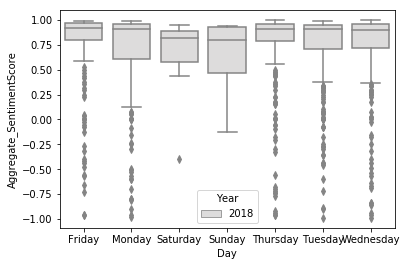

In [16]:
# Boxplot to show sentiment analysis of the extracted articles over the days through the date range.

sns.boxplot(x="Day",y="Aggregate_SentimentScore",hue="Year",data=df, palette="coolwarm")

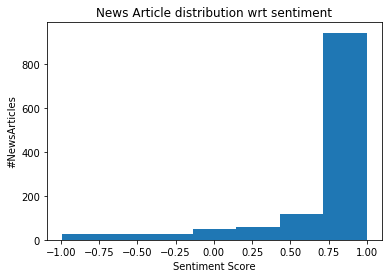

In [17]:
#for continuous values
fig=plt.figure() #Plots in matplotlib reside within a figure object, use plt.figure to create new figure
#Create one or more subplots using add_subplot, because you can't create blank figure
ax = fig.add_subplot(1,1,1)
#Variable
ax.hist(df['Aggregate_SentimentScore'],bins=7) 
#Labels and Title
plt.title('News Article distribution wrt sentiment')
plt.xlabel('Sentiment Score')
plt.ylabel('#NewsArticles')
plt.show()

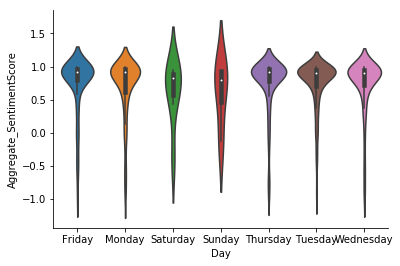

In [18]:
# Distribution of Sentiment of news articles over the days in the given date range.
sns.violinplot(df['Day'], df['Aggregate_SentimentScore']) #Variable Plot
sns.despine()


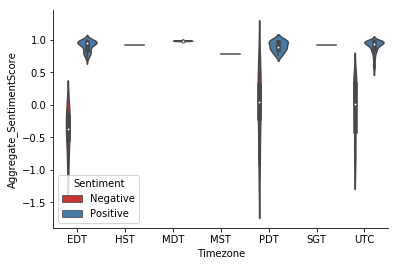

In [19]:
# Distribution of Sentiment of news articles over the timezone in the given date range.
sns.violinplot(df['Timezone'], df['Aggregate_SentimentScore'], hue=df['Sentiment'],palette='Set1') #Variable Plot
sns.despine()

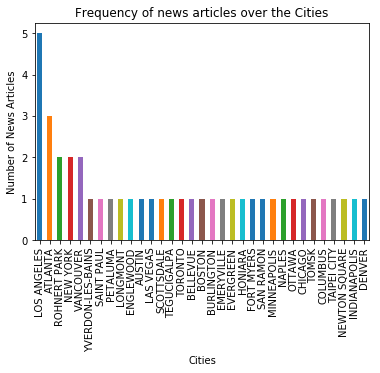

In [20]:
# Slicing the data to view the plots more clearly.
# Frequency of news articles from the following locations during this time.
temp_df = df[(df['Date_time'] > '2018-08-08 23:00:00') & (df['Date_time'] < '2018-08-09 12:00:00')]

temp_df["City"].value_counts().plot.bar()
plt.title('Frequency of news articles over the Cities')
plt.xlabel('Cities')
plt.ylabel('Number of News Articles')
#plt.legend()
plt.show()

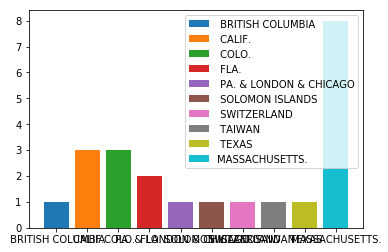

In [21]:
# Showing the frequency of news article with respect to State within the certain date range.

# Slicing the data for pictorial representation.
#print(df.head(2))
#tempo_df = df[(df['Date_time'] > '2018-08-08 16:00:00') & (df['Date_time'] < '2018-08-09 6:00:00')]

temp_df = df[(df['Date_time'] > '2018-08-08 23:00:00') & (df['Date_time'] < '2018-08-09 6:00:00')]

labels = []
for i, dfi in enumerate(temp_df.groupby(["State"])):
    labels.append(dfi[0])
    plt.bar(i, dfi[1].count(), label=dfi[0])
plt.xticks(range(len(labels)), labels)
plt.legend()
plt.show()

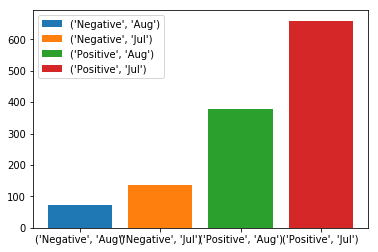

In [22]:
# Showing the frequency of news article with respect to month and sentiment.

labels = []
for i, dfi in enumerate(df.groupby(["Sentiment","Month"])):
    labels.append(dfi[0])
    plt.bar(i, dfi[1].count(), label=dfi[0])
plt.xticks(range(len(labels)), labels)
plt.legend()
plt.show()

Text(0.5,0,'Dates of Month')

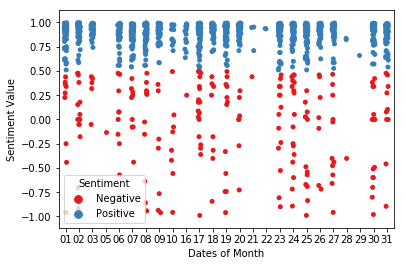

In [23]:
# Showcasing the sentiment over the dates over the time.
pp = sns.stripplot(x="DayDate", y="Aggregate_SentimentScore", data=df, hue='Sentiment',palette='Set1')
pp.set_ylabel("Sentiment Value")
pp.set_xlabel("Dates of Month")

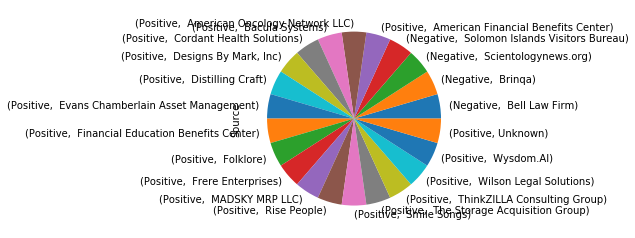

In [24]:
# Slicing the data for pictorial representation.
temp_df = df[(df['Date_time'] > '2018-08-08 12:00:00') & (df['Date_time'] < '2018-08-09 6:00:00')]
#temp_df
# Showing the sources of news articles that bring positive negative or neutral source.
temp_df.groupby("Sentiment")["Source"].value_counts().plot.pie()
plt.gca().set_aspect("equal")

In [25]:
# Analysis of trending news City location.
counts_city = collections.Counter(df['City'])
new_list_city = sorted(counts_city.items(), key = lambda x:x[1], reverse = True)
#new_lis
cityDF = pd.DataFrame(new_list_city, columns=['City', 'Frequency'])
cityDF.head(10)


,City,Frequency
0,LOS ANGELES,65
1,NEW YORK,59
2,ATLANTA,32
3,ROHNERT PARK,32
4,CHICAGO,31
5,SAN FRANCISCO,26
6,EMERYVILLE,25
7,SAN RAMON,23
8,PETALUMA,22
9,SAN DIEGO,21


In [26]:
# Analysis of trending news State location.
counts_state = collections.Counter(df['State'])
new_list_state = sorted(counts_state.items(), key = lambda x:x[1], reverse = True)
#new_lis
stateDF = pd.DataFrame(new_list_state, columns=['State', 'Frequency'])
stateDF.head(10)


,State,Frequency
0,MASSACHUSETTS.,441
1,CALIF.,208
2,FLA.,74
3,TEXAS,35
4,N.J.,24
5,PA.,21
6,N.Y.,20
7,MASS.,20
8,VA.,17
9,COLO.,16


In [27]:
# Trying to get latitude and longitude, but this sometimes works, this could be used to plot on worldmap.
ltd = []
for city, freq in cityDF.items():
    ltd.append(geocoder.google(city).latlng)
#print(ltd)
    

In [28]:
# Analysis of trending news Country location.
# Sorting for the top 10.

counts_country = collections.Counter(df['Country'])
new_list_country = sorted(counts_country.items(), key = lambda x:x[1], reverse = True)
#new_lis
countryDF = pd.DataFrame(new_list_country, columns=['Country', 'Frequency'])
countryDF.head(10)

,Country,Frequency
0,USA,1246
1,PORTUGAL,1
2,TEXAS,1


In [29]:
# Analysis of trending Categories with frequency within a specified date range.
catg = []
for index, row in df.iterrows():
    for item in row['Category']:
        catg.append(item)

#print(len(catg))

# Sorting for the top 10.
counts_catg = collections.Counter(catg)
new_list_catgs = sorted(counts_catg.items(), key = lambda x:x[1], reverse = True)

#new_lis
catgDF = pd.DataFrame(new_list_catgs, columns=['Category', 'Frequency'])
catgDF.head(10)

,Category,Frequency
0,Healthcare,88
1,Business Technology,73
2,Financial News,66
3,Financing,58
4,Student Loans,58
5,Business,54
6,Cryptocurrency,35
7,Entrepreneurship,31
8,Entertainment,30
9,Books,29


In [30]:
# Analysis of trending tags with frequency within a specified date range.

import collections
kw = []
for index, row in df.iterrows():
    for item in row['Tags']:
        kw.append(item)

#print(len(kw))
#print(kw.unique())

# Sorting for the top 10.

counts_kw = collections.Counter(kw)
new_lis_kw = sorted(counts_kw.items(), key = lambda x:x[1], reverse = True)
#new_lis
TagsDF = pd.DataFrame(new_lis_kw, columns=['Tags', 'Frequency'])
TagsDF.head(10)

,Tags,Frequency
0,income-driven repayment,55
1,blockchain,34
2,student loan repayment,30
3,student loans,29
4,federal student loans,26
5,entrepreneurship,24
6,technology,24
7,student debt,24
8,Invents Company,24
9,cryptocurrency,22


In [31]:
# Analysis of trending Sources with frequency within a specified date range.

import collections
src = []
for index, row in df.iterrows():
    src.append(row['Source'])

#print(len(src))

# Sorting for the top 10.
counts_src = collections.Counter(src)
new_lis_src = sorted(counts_src.items(), key = lambda x:x[1], reverse = True)
SourceDF = pd.DataFrame(new_lis_src, columns=['Source', 'Frequency'])
SourceDF.head(10)

,Source,Frequency
0,Ameritech Financial,32
1,Financial Education Benefits Center,24
2,Invents Company,24
3,Frere Enterprises,22
4,American Financial Benefits Center,22
5,Unknown,20
6,Covenant Books,19
7,Scientologynews.org,14
8,Web Presence LLC,11
9,International Association of Women,9


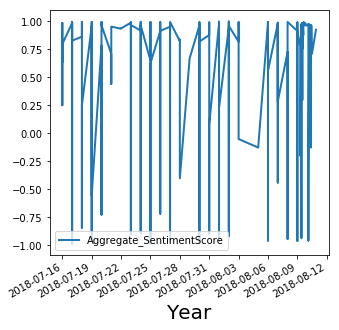

In [32]:
# Time series Analysis of sentiment over the time.

df.set_index('Date_time', inplace=True)
df[['Aggregate_SentimentScore']].plot(figsize=(5,5), linewidth=2, fontsize=10)
plt.xlabel('Year', fontsize=20);

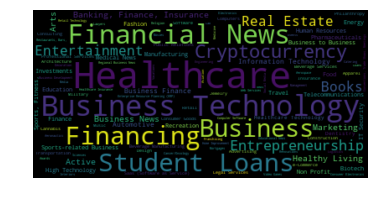

In [33]:
# Wordcloud of Category with frequency.

from wordcloud import WordCloud
    
d = {}
for a, x in catgDF.values:
    d[a] = x

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

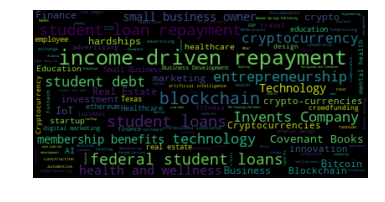

In [34]:
# Wordcloud of Tags with frequency.

from wordcloud import WordCloud
    
d = {}
for a, x in TagsDF.values:
    d[a] = x

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

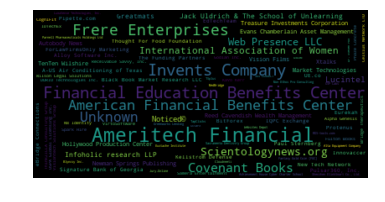

In [35]:
# Wordcloud of Source with frequency.

from wordcloud import WordCloud
    
#wordcloud_src = WordCloud(width = 1000, height = 500).generate(" ".join(SourceDF['Source'].tolist()))
#plt.imshow(wordcloud, interpolation='bilinear')
d = {}
for a, x in SourceDF.values:
    d[a] = x

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [36]:
# References:

# https://holwech.github.io/blog/Automatic-news-scraper/
# https://opensourceforu.com/2016/07/22843/
# https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html
# https://stackabuse.com/converting-strings-to-datetime-in-python/
# https://www.saltycrane.com/blog/2009/05/converting-time-zones-datetime-objects-python/
# https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
# http://www.vogella.com/tutorials/JavaRegularExpressions/article.html
# https://python-graph-gallery.com/map/